In [ ]:
import os
import numpy as np
import pandas as pd

for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

/kaggle/input/fake-news-detection-datasets/News _dataset/True.csv
/kaggle/input/fake-news-detection-datasets/News _dataset/Fake.csv


In [ ]:
!pip install --quiet nltk textstat scikit-learn tensorflow matplotlib seaborn

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 105.3/105.3 kB 4.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 939.4/939.4 kB 22.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.1/2.1 MB 55.8 MB/s eta 0:00:00


In [ ]:
import re
import nltk
import textstat
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize, sent_tokenize
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import (
    accuracy_score, precision_score, recall_score, f1_score,
    confusion_matrix, classification_report,
    average_precision_score, jaccard_score, ConfusionMatrixDisplay
)
from sklearn.neighbors import KNeighborsClassifier
from sklearn.ensemble import RandomForestClassifier
import tensorflow as tf
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Embedding, LSTM, GRU, Bidirectional, Dense, Dropout
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint
import matplotlib.pyplot as plt
import seaborn as sns

In [ ]:
nltk.download('punkt')
nltk.download('stopwords')

[nltk_data] Downloading package punkt to /usr/share/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package stopwords to /usr/share/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.


True

In [ ]:
folder = '/kaggle/input/fake-news-detection-datasets/News _dataset/'

df_real = pd.read_csv(os.path.join(folder, 'True.csv'))
df_fake = pd.read_csv(os.path.join(folder, 'Fake.csv'))

# Label encoding: 1 = real, 0 = fake
df_real['label'] = 1
df_fake['label'] = 0

# Combine and shuffle
df = pd.concat([df_real[['text','label']], df_fake[['text','label']]], ignore_index=True)
df = df.sample(frac=1, random_state=42).reset_index(drop=True)
print(df.label.value_counts())
df.head()

label
0    23481
1    21417
Name: count, dtype: int64


,text,label
0,"Donald Trump s White House is in chaos, and th...",0
1,Now that Donald Trump is the presumptive GOP n...,0
2,Mike Pence is a huge homophobe. He supports ex...,0
3,SAN FRANCISCO (Reuters) - California Attorney ...,1
4,Twisted reasoning is all that comes from Pelos...,0


In [ ]:
# Preprocessing
t_stop = set(stopwords.words('english'))

from nltk.stem import PorterStemmer
stemmer = PorterStemmer()

def clean_text(text):
    text = str(text).lower()
    text = re.sub(r'http\S+|www\S+|https\S+', '', text)
    text = re.sub(r'[^a-zA-Z\s]', '', text)
    tokens = text.split()
    tokens = [stemmer.stem(w) for w in tokens if w not in t_stop]
    return ' '.join(tokens)

# Apply cleaning
[df.head()]
df['clean_text'] = df['text'].apply(clean_text)
df.head()

,text,label,clean_text
0,"Donald Trump s White House is in chaos, and th...",0,donald trump white hous chao tri cover russia ...
1,Now that Donald Trump is the presumptive GOP n...,0,donald trump presumpt gop nomine time rememb c...
2,Mike Pence is a huge homophobe. He supports ex...,0,mike penc huge homophob support exgay convers ...
3,SAN FRANCISCO (Reuters) - California Attorney ...,1,san francisco reuter california attorney gener...
4,Twisted reasoning is all that comes from Pelos...,0,twist reason come pelosi day especi promin dem...


In [ ]:
# Feature extractor
def extract_features(text):
    words = word_tokenize(text)
    sents = sent_tokenize(text)
    wc = len(words)
    sc = len(sents)
    avg_ws = wc/sc if sc else 0
    swc = sum(1 for w in words if w.lower() in t_stop)
    lex_div = len(set(words))/wc if wc else 0
    # Readability
    fre = textstat.flesch_reading_ease(text)
    si = textstat.smog_index(text)
    fk = textstat.flesch_kincaid_grade(text)
    ari = textstat.automated_readability_index(text)
    return [wc, sc, avg_ws, swc, lex_div, fre, si, fk, ari]

# Apply feature extraction
feat_cols = [
    'word_count','sentence_count','avg_words_per_sentence',
    'stopword_count','lexical_diversity','flesch_reading_ease',
    'smog_index','flesch_kincaid_grade','automated_readability_index'
]

df['features'] = df['text'].apply(extract_features)
feat_df = pd.DataFrame(df['features'].tolist(), columns=feat_cols)

# Combine with labels
data_feat = pd.concat([feat_df, df['label']], axis=1)

In [ ]:
X_feat = data_feat.drop('label', axis=1)
X_text = df['clean_text']
y = data_feat['label']

# Split
Xf_train, Xf_test, Xt_train, Xt_test, y_train, y_test = train_test_split(
    X_feat, X_text, y, test_size=0.2, random_state=42, stratify=y
)

# Scale features
scaler = StandardScaler()
Xf_train_scaled = scaler.fit_transform(Xf_train)
Xf_test_scaled = scaler.transform(Xf_test)


=== KNN ===
              precision    recall  f1-score   support

           0     0.8741    0.8431    0.8583      4696
           1     0.8344    0.8669    0.8504      4284

    accuracy                         0.8545      8980
   macro avg     0.8543    0.8550    0.8543      8980
weighted avg     0.8552    0.8545    0.8545      8980



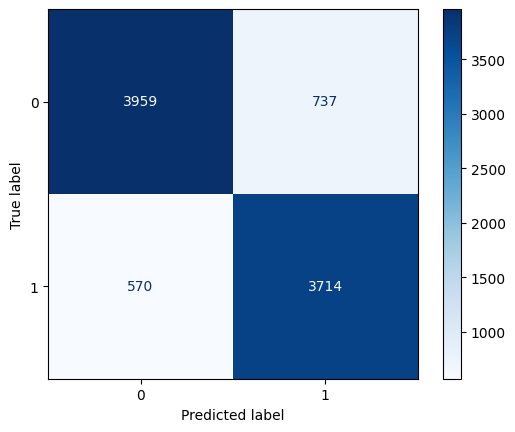

mAP: 0.9038, IoU: 0.7397

=== Random Forest ===
              precision    recall  f1-score   support

           0     0.8993    0.9146    0.9069      4696
           1     0.9046    0.8877    0.8961      4284

    accuracy                         0.9018      8980
   macro avg     0.9020    0.9012    0.9015      8980
weighted avg     0.9018    0.9018    0.9017      8980



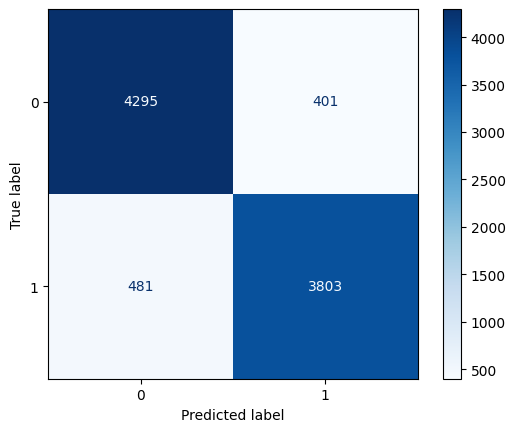

mAP: 0.9611, IoU: 0.8117


In [ ]:
knn = KNeighborsClassifier(n_neighbors=5)
rf  = RandomForestClassifier(n_estimators=100, random_state=42)

knn.fit(Xf_train_scaled, y_train)
rf.fit(Xf_train_scaled, y_train)

# Evaluation
def evaluate_model(y_true, y_pred, y_prob, name):
    print(f"\n=== {name} ===")
    print(classification_report(y_true, y_pred, digits=4))
    cm = confusion_matrix(y_true, y_pred)
    disp = ConfusionMatrixDisplay(cm, display_labels=[0,1])
    disp.plot(cmap='Blues')
    plt.show()
    ap_pos = average_precision_score(y_true, y_prob)
    ap_neg = average_precision_score(1-y_true, 1-y_prob)
    print(f"mAP: {(ap_pos+ap_neg)/2:.4f}, IoU: {jaccard_score(y_true, y_pred):.4f}")

# Predict & evaluate
for name, model in [('KNN', knn), ('Random Forest', rf)]:
    yp = model.predict(Xf_test_scaled)
    yp_prob = model.predict_proba(Xf_test_scaled)[:,1]
    evaluate_model(y_test, yp, yp_prob, name)

In [ ]:
max_vocab = 20000
max_len   = 200

tok = Tokenizer(num_words=max_vocab, oov_token='<OOV>')
tok.fit_on_texts(Xt_train)

train_seq = tok.texts_to_sequences(Xt_train)
test_seq  = tok.texts_to_sequences(Xt_test)

train_pad = pad_sequences(train_seq, maxlen=max_len, padding='post', truncating='post')
test_pad  = pad_sequences(test_seq,  maxlen=max_len, padding='post', truncating='post')

In [ ]:
def build_rnn(vocab_size, embed_dim=64, units=64, dropout=0.2):
    model = Sequential([
        Embedding(vocab_size, embed_dim),
        GRU(units, dropout=dropout, recurrent_dropout=dropout),
        Dense(1, activation='sigmoid')
    ])
    model.compile(loss='binary_crossentropy', optimizer=Adam(1e-3), metrics=['accuracy'])
    return model

def build_bi_rnn(vocab_size, embed_dim=64, units=64, dropout=0.2):
    model = Sequential([
        Embedding(vocab_size, embed_dim),
        Bidirectional(GRU(units, dropout=dropout, recurrent_dropout=dropout)),
        Dense(1, activation='sigmoid')
    ])
    model.compile(loss='binary_crossentropy', optimizer=Adam(1e-3), metrics=['accuracy'])
    return model

def build_lstm(vocab_size, embed_dim=64, units=64, dropout=0.2):
    model = Sequential([
        Embedding(vocab_size, embed_dim),
        LSTM(units, dropout=dropout, recurrent_dropout=dropout),
        Dense(1, activation='sigmoid')
    ])
    model.compile(loss='binary_crossentropy', optimizer=Adam(1e-3), metrics=['accuracy'])
    return model

def build_bi_lstm(vocab_size, embed_dim=64, units=64, dropout=0.2):
    model = Sequential([
        Embedding(vocab_size, embed_dim),
        Bidirectional(LSTM(units, dropout=dropout, recurrent_dropout=dropout)),
        Dense(1, activation='sigmoid')
    ])
    model.compile(loss='binary_crossentropy', optimizer=Adam(1e-3), metrics=['accuracy'])
    return model

In [ ]:
callbacks = [
    # EarlyStopping(monitor='val_loss', patience=3, restore_best_weights=True),
    ModelCheckpoint('best_model.keras', monitor='val_loss', save_best_only=True)
]

epochs_rnn = 15  # Epochs for RNN
epochs_others = 5  # Epochs for Bi-RNN, LSTM, and Bi-LSTM
batch_size = 64

dl_models = {
    'RNN': build_rnn(max_vocab),
    'Bi-RNN': build_bi_rnn(max_vocab),
    'LSTM': build_lstm(max_vocab),
    'Bi-LSTM': build_bi_lstm(max_vocab)
}

for name, model in dl_models.items():
    print(f"\nTraining {name}")

    current_epochs = epochs_rnn if name == 'RNN' else epochs_others

    model.fit(
        train_pad, y_train,
        validation_data=(test_pad, y_test),
        epochs=current_epochs,
        batch_size=batch_size,
        callbacks=callbacks,
        verbose=2
    )


Training RNN
Epoch 1/15
562/562 - 216s - 384ms/step - accuracy: 0.6464 - loss: 29492.4512 - val_accuracy: 0.6452 - val_loss: 0.6337
Epoch 2/15
562/562 - 206s - 367ms/step - accuracy: 0.6867 - loss: 52.9596 - val_accuracy: 0.6318 - val_loss: 0.6216
Epoch 3/15
562/562 - 206s - 366ms/step - accuracy: 0.6937 - loss: 1108.0442 - val_accuracy: 0.6404 - val_loss: 0.6148
Epoch 4/15
562/562 - 207s - 368ms/step - accuracy: 0.6998 - loss: 20.4102 - val_accuracy: 0.6463 - val_loss: 0.6055
Epoch 5/15
562/562 - 206s - 367ms/step - accuracy: 0.7121 - loss: 1.9174 - val_accuracy: 0.6497 - val_loss: 0.6013
Epoch 6/15
562/562 - 207s - 369ms/step - accuracy: 0.6338 - loss: 38162907136.0000 - val_accuracy: 0.5827 - val_loss: 0.6533
Epoch 7/15
562/562 - 205s - 366ms/step - accuracy: 0.6640 - loss: 0.5881 - val_accuracy: 0.6282 - val_loss: 0.6392
Epoch 8/15
562/562 - 207s - 368ms/step - accuracy: 0.6791 - loss: 0.5611 - val_accuracy: 0.6300 - val_loss: 0.6326
Epoch 9/15
562/562 - 207s - 368ms/step - accura


=== RNN Evaluation ===
281/281 ━━━━━━━━━━━━━━━━━━━━ 24s 86ms/step

=== RNN ===
              precision    recall  f1-score   support

           0     0.5990    0.9048    0.7208      4696
           1     0.7631    0.3361    0.4667      4284

    accuracy                         0.6335      8980
   macro avg     0.6811    0.6205    0.5938      8980
weighted avg     0.6773    0.6335    0.5996      8980



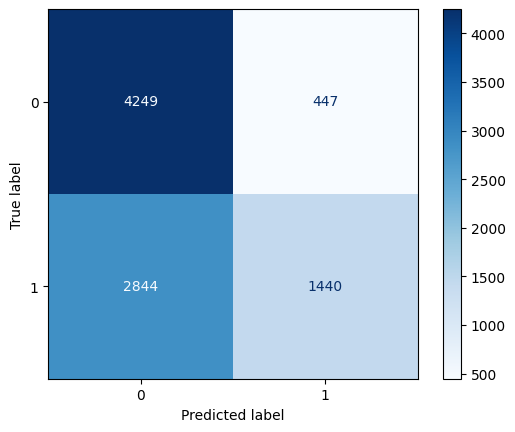

mAP: 0.6995, IoU: 0.3044

=== Bi-RNN Evaluation ===
281/281 ━━━━━━━━━━━━━━━━━━━━ 31s 108ms/step

=== Bi-RNN ===
              precision    recall  f1-score   support

           0     0.9968    0.9962    0.9965      4696
           1     0.9958    0.9965    0.9961      4284

    accuracy                         0.9963      8980
   macro avg     0.9963    0.9963    0.9963      8980
weighted avg     0.9963    0.9963    0.9963      8980



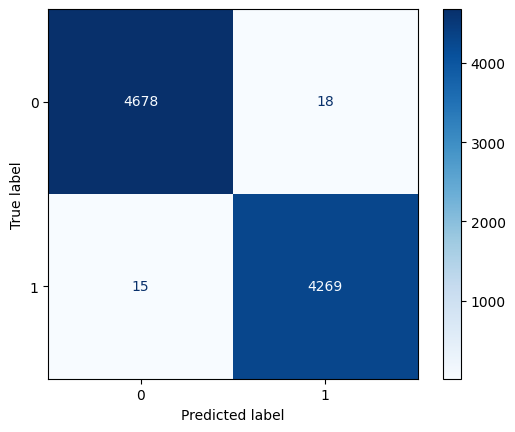

mAP: 0.9997, IoU: 0.9923

=== LSTM Evaluation ===
281/281 ━━━━━━━━━━━━━━━━━━━━ 22s 79ms/step

=== LSTM ===
              precision    recall  f1-score   support

           0     0.9522    0.9883    0.9699      4696
           1     0.9866    0.9456    0.9657      4284

    accuracy                         0.9679      8980
   macro avg     0.9694    0.9669    0.9678      8980
weighted avg     0.9686    0.9679    0.9679      8980



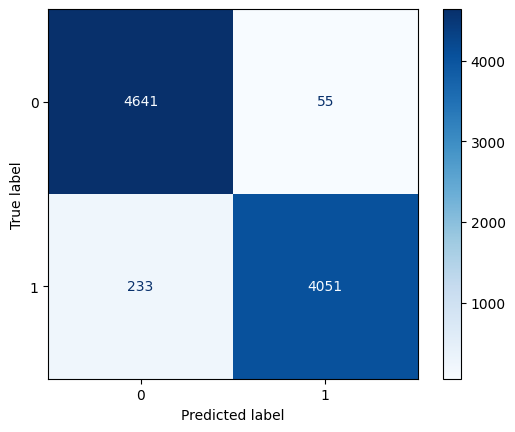

mAP: 0.9851, IoU: 0.9336

=== Bi-LSTM Evaluation ===
281/281 ━━━━━━━━━━━━━━━━━━━━ 26s 92ms/step

=== Bi-LSTM ===
              precision    recall  f1-score   support

           0     0.9994    0.9987    0.9990      4696
           1     0.9986    0.9993    0.9989      4284

    accuracy                         0.9990      8980
   macro avg     0.9990    0.9990    0.9990      8980
weighted avg     0.9990    0.9990    0.9990      8980



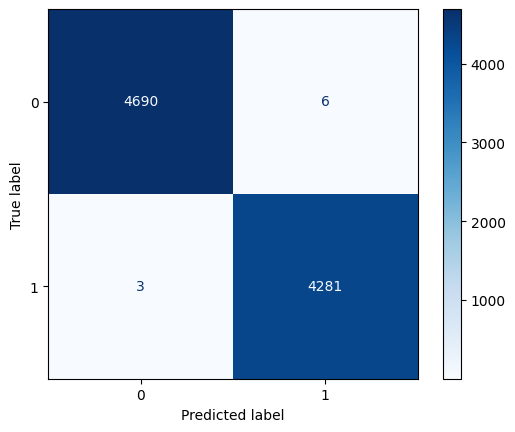

mAP: 1.0000, IoU: 0.9979


In [ ]:
for name, model in dl_models.items():
    print(f"\n=== {name} Evaluation ===")
    probs = model.predict(test_pad).flatten()
    preds = (probs > 0.5).astype(int)
    evaluate_model(y_test, preds, probs, name)